Импорт необходимых модулей. Для построения модели будем использовать XGB Regressor, как хорошо зарекомендовавший себя ансамбль методов.

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

Подгружаем данные с результатами измерений, с тренировочным данными о качестве и с данными для прогноза.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Severstal_test/X_data.csv', sep=',', delimiter=';', parse_dates=True)
data = data.rename(columns={'Unnamed: 0':'Date'})
y_data = pd.read_csv('/content/drive/MyDrive/Severstal_test/Y_train.csv', header=None, sep=',', delimiter=';')
y_data = y_data.rename(columns={0: 'Date', 1: 'Target'})
y_test = pd.read_csv('/content/drive/MyDrive/Severstal_test/Y_submit.csv', header=None, sep=',', delimiter=';')
y_test = y_test.rename(columns={0: 'Date', 1: 'Target'})

Данные о качестве продукции даны с интервалом в 1 час. Также в задании сказано, что сырье проводит в обжиговой заготовке 1 час. Поэтому будет корректнее строить модель прогнозирования на основе данных, осредненных за 1 час. В следующих ячейках производится осреднение этих данных, а также получение тренировочного датасета. 

In [ ]:
data_mean = data.copy()
data_mean.iloc[:, 1:] = data.iloc[:, 1:].rolling(60).mean()

In [ ]:
train = pd.merge(left=data_mean, right=y_data, how="inner", on='Date',)


In [ ]:
X = train.drop(['Date', 'Target'], axis=1)
y = train.Target
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29184 entries, 0 to 29183
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   T_data_1_1  29184 non-null  float64
 1   T_data_1_2  29184 non-null  float64
 2   T_data_1_3  29184 non-null  float64
 3   T_data_2_1  29184 non-null  float64
 4   T_data_2_2  29184 non-null  float64
 5   T_data_2_3  29184 non-null  float64
 6   T_data_3_1  29184 non-null  float64
 7   T_data_3_2  29184 non-null  float64
 8   T_data_3_3  29184 non-null  float64
 9   T_data_4_1  29184 non-null  float64
 10  T_data_4_2  29184 non-null  float64
 11  T_data_4_3  29184 non-null  float64
 12  T_data_5_1  29184 non-null  float64
 13  T_data_5_2  29184 non-null  float64
 14  T_data_5_3  29184 non-null  float64
 15  H_data      29184 non-null  float64
 16  AH_data     29184 non-null  float64
dtypes: float64(17)
memory usage: 4.0 MB


Мы видим, что в тренировочном датасете ровно столько же записей, как и в файле с данными об измеренном качестве. Тренировочный сет занимает всего 4 МБ памяти, так что нет смысла проводить оптимизацию форматов хранения и можно работать с типом float64.
Также надо выделить данные для тех моментов времени, для которых необходимо предсказать качество продукции:

In [ ]:
test = pd.merge(left=data_mean, right=y_test, how="inner", on='Date')
X_test = test.drop(['Date', 'Target'], axis=1)

Создадим словарь с параметрами модели. По договоренности с заказчиком будем использовать метод оценки точности предсказания MAE. Среда Google Colaboratory позволяет использовать для работы GPU, укажем это в параметрах.

In [ ]:
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 1e-2,
    'seed': 42,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'n_estimators': 10000,
    'max_depth': 8,
    'alpha': 10,
    'lambda': 1e-1,
    'min_child_weight': 100,
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
}

Для повышения точности предсказания будем использовать метод кросс-валидации с разбивкой на 5 частей. После обучения и валидации модели на каждой разбивке используем ее для предсказания целевых значений. В итоге, на выходе у нас будет 5 предсказанных значений для каждой интересующей нас точки, и в качестве итогового ответа будем использовать среднее значение пяти полученных ответов. 

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
preds = []
scores = []

for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
  X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
  X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

  model = XGBRegressor(**xgb_params)
  model.fit(X_train, y_train,
            eval_set=[(X_valid,y_valid)],
            early_stopping_rounds=100,
            verbose=10000)
  
  pred_valid = model.predict(X_valid)
  mae = mean_absolute_error(y_valid, pred_valid)
  scores.append(mae)
  print(f"Fold: {fold + 1} Score: {mae}")
  print('||'*20)

  test_preds = model.predict(X_test)
  preds.append(test_preds)

print(f"Overall MAE: {np.mean(scores)}")

predictions = np.mean(np.column_stack(preds), axis=1)
y_test['Target'] = predictions

[0]	validation_0-mae:398.105
Will train until validation_0-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[7029]	validation_0-mae:7.87196

Fold: 1 Score: 7.871958555006217
||||||||||||||||||||||||||||||||||||||||
[0]	validation_0-mae:397.926
Will train until validation_0-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[9028]	validation_0-mae:7.60977

Fold: 2 Score: 7.6097721546219494
||||||||||||||||||||||||||||||||||||||||
[0]	validation_0-mae:398.498
Will train until validation_0-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[8144]	validation_0-mae:7.71263

Fold: 3 Score: 7.712629717221831
||||||||||||||||||||||||||||||||||||||||
[0]	validation_0-mae:398.522
Will train until validation_0-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[7001]	validation_0-mae:7.59783

Fold: 4 Score: 7.597833531144263
||||||||||||||||||||||||||||||||||||||||
[0]	validation_0-mae:398.36
Will train until validation_0-mae hasn't improved in 100 rounds

Сохраняем полученные предсказания в csv файл:

In [ ]:
y_test.to_csv('./submission_test2.csv', index=False, header=False)

Определим наиболее важные с точки зрения предсказания параметры:

In [ ]:
from matplotlib import pyplot
from xgboost import plot_importance

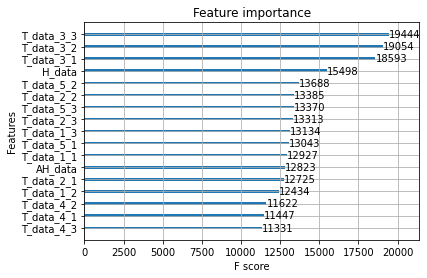

In [ ]:

plot_importance(model)

Наиболее важными данными являются температура в третьей камере и высота слоя сырья.